[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Tue Apr  1 12:50:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 72.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [5]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-04-01 12:52:48--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-04-01 12:52:48 (86.2 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:00<00:00, 117MB/s]


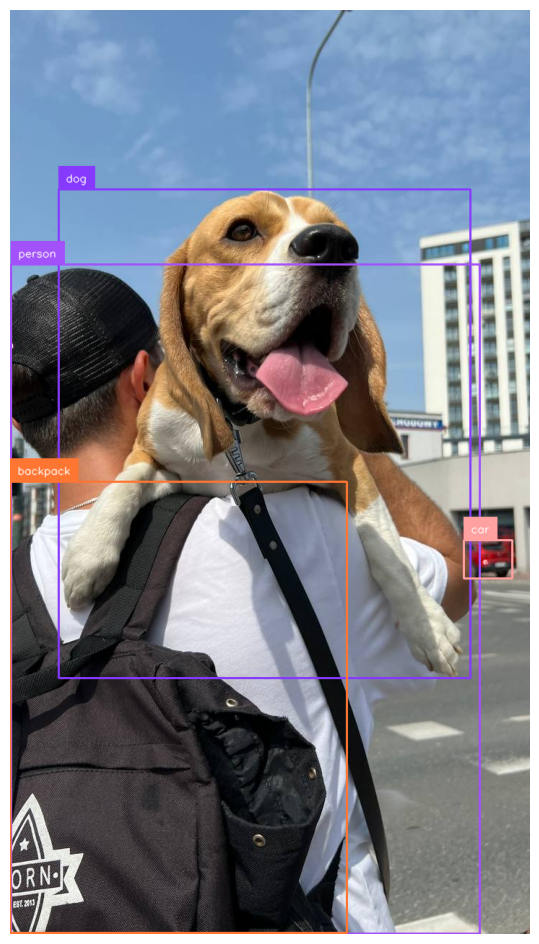

In [6]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [8]:
from roboflow import download_dataset

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="msK06YboWHth1onOWmia")
project = rf.workspace("macroalgae-recognition-model").project("tuscan-macroalgae-recognition")
version = project.version(4)
dataset = version.download("yolov12")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to tuscan-macroalgae-recognition-4 in yolov12:: 100%|██████████| 2018/2018 [00:07<00:00, 263.37it/s]


In [21]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [19]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [22]:
!cat {dataset.location}/data.yaml

train: /content/tuscan-macroalgae-recognition-4/train/images
val: /content/tuscan-macroalgae-recognition-4/val/images
test: /content/tuscan-macroalgae-recognition-4/test/images

nc: 3
names: ['Cystoseira sl', 'Posidonia oceanica', 'Sargassum vulgare']

roboflow:
  workspace: macroalgae-recognition-model
  project: tuscan-macroalgae-recognition
  version: 4
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [23]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'/content/tuscan-macroalgae-recognition-4/data.yaml', epochs=50)

New https://pypi.org/project/ultralytics/8.3.99 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/tuscan-macroalgae-recognition-4/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=No

100%|██████████| 755k/755k [00:00<00:00, 20.3MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 91.9MB/s]


AMP: checks passed ✅


train: Scanning /content/tuscan-macroalgae-recognition-4/train/labels... 736 images, 96 backgrounds, 0 corrupt: 100%|██████████| 736/736 [00:00<00:00, 1138.94it/s]

train: New cache created: /content/tuscan-macroalgae-recognition-4/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/tuscan-macroalgae-recognition-4/valid/labels... 196 images, 24 backgrounds, 0 corrupt: 100%|██████████| 196/196 [00:00<00:00, 545.55it/s]

val: New cache created: /content/tuscan-macroalgae-recognition-4/valid/labels.cache


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.71G       3.17      3.968      4.222         49        640: 100%|██████████| 46/46 [01:07<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]

                   all        196        277    0.00411      0.735    0.00811    0.00358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.69G      3.167      3.845      4.037         56        640: 100%|██████████| 46/46 [01:04<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.74s/it]

                   all        196        277    0.00247      0.543     0.0248    0.00483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.68G      3.054      3.707      3.705         59        640: 100%|██████████| 46/46 [00:59<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.53s/it]

                   all        196        277    0.00362      0.692     0.0263    0.00679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.81G      2.867      3.642      3.467         65        640: 100%|██████████| 46/46 [00:57<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]

                   all        196        277     0.0147        0.2    0.00965    0.00253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.82G      2.737       3.56       3.33         72        640: 100%|██████████| 46/46 [00:59<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


                   all        196        277     0.0536      0.192     0.0466    0.00868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.81G       2.68      3.525      3.223         59        640: 100%|██████████| 46/46 [00:58<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]

                   all        196        277      0.754     0.0714     0.0523     0.0116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.82G      2.623      3.524      3.176         59        640: 100%|██████████| 46/46 [00:57<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.63s/it]

                   all        196        277      0.169      0.206      0.115     0.0372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.83G      2.575      3.494      3.111         81        640: 100%|██████████| 46/46 [00:57<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]

                   all        196        277      0.167      0.344       0.12     0.0325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.84G       2.49      3.463      3.051         40        640: 100%|██████████| 46/46 [01:00<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]

                   all        196        277      0.303      0.295      0.192     0.0849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.81G      2.452      3.406      3.008         55        640: 100%|██████████| 46/46 [00:57<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


                   all        196        277      0.152      0.245      0.115     0.0493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.85G      2.434      3.421      2.945         54        640: 100%|██████████| 46/46 [00:59<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]

                   all        196        277      0.126      0.221      0.065     0.0235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.83G      2.407      3.337       2.89         59        640: 100%|██████████| 46/46 [00:56<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]

                   all        196        277      0.148      0.137     0.0764     0.0268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.84G      2.362      3.322      2.865         69        640: 100%|██████████| 46/46 [00:59<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


                   all        196        277      0.182      0.302      0.135     0.0514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.83G       2.35      3.266      2.832         69        640: 100%|██████████| 46/46 [00:55<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


                   all        196        277      0.243      0.341      0.204     0.0908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.84G      2.323      3.266      2.807         57        640: 100%|██████████| 46/46 [00:57<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        196        277      0.279       0.31      0.243      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.81G      2.245      3.178      2.731         65        640: 100%|██████████| 46/46 [00:57<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


                   all        196        277      0.284      0.337      0.229      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.82G      2.246      3.126      2.682         54        640: 100%|██████████| 46/46 [00:56<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.33s/it]


                   all        196        277        0.4      0.313      0.214      0.087

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.81G      2.209      3.079      2.647         63        640: 100%|██████████| 46/46 [00:57<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


                   all        196        277      0.334      0.338      0.238      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.84G      2.201      3.055      2.619         78        640: 100%|██████████| 46/46 [00:56<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


                   all        196        277      0.302      0.346      0.243       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.86G      2.166      3.026      2.593         57        640: 100%|██████████| 46/46 [00:57<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        196        277      0.252      0.323      0.209     0.0952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.65G      2.135      2.955      2.538         76        640: 100%|██████████| 46/46 [00:55<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.40s/it]

                   all        196        277      0.253      0.314      0.196     0.0965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.84G      2.086      2.915      2.511         59        640: 100%|██████████| 46/46 [00:56<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]


                   all        196        277      0.376      0.342      0.286      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.67G       1.97      2.819      2.405         77        640: 100%|██████████| 46/46 [00:55<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]

                   all        196        277       0.41      0.394      0.312       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.81G      1.938      2.759      2.376         61        640: 100%|██████████| 46/46 [00:56<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

                   all        196        277       0.41      0.397      0.335      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.67G      1.935      2.741      2.351         45        640: 100%|██████████| 46/46 [00:56<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]


                   all        196        277      0.283      0.375      0.222      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.81G      1.854      2.655      2.273         56        640: 100%|██████████| 46/46 [00:57<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

                   all        196        277      0.452      0.387      0.337      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.84G      1.834      2.636      2.251         55        640: 100%|██████████| 46/46 [00:56<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]


                   all        196        277      0.359      0.426       0.32      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.83G      1.807      2.575      2.219         69        640: 100%|██████████| 46/46 [00:58<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

                   all        196        277      0.402      0.432      0.341        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.82G      1.782      2.552      2.202         63        640: 100%|██████████| 46/46 [00:56<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


                   all        196        277      0.431      0.396      0.355      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.81G      1.745      2.476      2.143         57        640: 100%|██████████| 46/46 [00:58<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        196        277      0.501      0.401       0.37      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.82G      1.689      2.411      2.085         81        640: 100%|██████████| 46/46 [00:57<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.46s/it]


                   all        196        277      0.434      0.452      0.345      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.83G      1.695      2.425      2.124         75        640: 100%|██████████| 46/46 [00:59<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.03s/it]

                   all        196        277      0.548      0.407      0.382      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.85G        1.7      2.423      2.087         51        640: 100%|██████████| 46/46 [00:57<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


                   all        196        277      0.444      0.454      0.384      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.83G        1.7      2.431       2.09         61        640: 100%|██████████| 46/46 [01:01<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.97s/it]

                   all        196        277      0.485      0.431      0.391      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.82G      1.658      2.369      2.059         63        640: 100%|██████████| 46/46 [00:57<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        196        277      0.442      0.481       0.39       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.81G      1.572      2.273      1.991         72        640: 100%|██████████| 46/46 [01:00<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:18<00:00,  2.59s/it]

                   all        196        277      0.548      0.435      0.443      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.82G      1.603      2.353      2.009         70        640: 100%|██████████| 46/46 [00:59<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.40s/it]


                   all        196        277      0.637      0.415      0.449      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.82G      1.556      2.223      1.967         61        640: 100%|██████████| 46/46 [00:58<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]

                   all        196        277       0.55      0.414      0.432      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.88G      1.603      2.295      1.999         64        640: 100%|██████████| 46/46 [00:56<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


                   all        196        277      0.638      0.408      0.449      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.81G      1.509      2.187      1.942         54        640: 100%|██████████| 46/46 [00:56<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


                   all        196        277      0.627      0.393      0.444      0.284
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.82G      1.568      2.529      2.183         21        640: 100%|██████████| 46/46 [01:06<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        196        277      0.699      0.422      0.461      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       6.8G      1.461      2.412      2.109         32        640: 100%|██████████| 46/46 [00:53<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


                   all        196        277      0.582      0.457      0.462      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.82G      1.414      2.333      2.071         23        640: 100%|██████████| 46/46 [01:01<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.46s/it]


                   all        196        277      0.674      0.459       0.48      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       6.8G      1.408      2.327       2.04         19        640: 100%|██████████| 46/46 [01:03<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.61s/it]

                   all        196        277      0.636      0.443      0.445      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.82G      1.369       2.26      2.032         22        640: 100%|██████████| 46/46 [01:03<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


                   all        196        277      0.659      0.441      0.489      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       6.8G      1.359      2.257      2.002         18        640: 100%|██████████| 46/46 [01:04<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]

                   all        196        277      0.647      0.447      0.478      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.82G      1.351      2.213      2.008         21        640: 100%|██████████| 46/46 [01:03<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]

                   all        196        277      0.691      0.423      0.495      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.81G      1.339      2.233      1.977         36        640: 100%|██████████| 46/46 [01:02<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        196        277      0.765      0.417      0.506      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.82G      1.334      2.203      1.985         18        640: 100%|██████████| 46/46 [01:02<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        196        277      0.636      0.461      0.508      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       6.8G      1.317      2.186      1.962         24        640: 100%|██████████| 46/46 [00:58<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        196        277      0.715      0.431      0.508      0.367



50 epochs completed in 1.006 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 18.6MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,075,369 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


                   all        196        277      0.636      0.461      0.508      0.371
         Cystoseira sl         68        102      0.515      0.431      0.488      0.389
    Posidonia oceanica         56         84       0.67      0.512       0.55      0.398
     Sargassum vulgare         56         91      0.721       0.44      0.486      0.326
Speed: 0.4ms preprocess, 6.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train5


In [29]:
import IPython.display
from IPython.display import display, Image

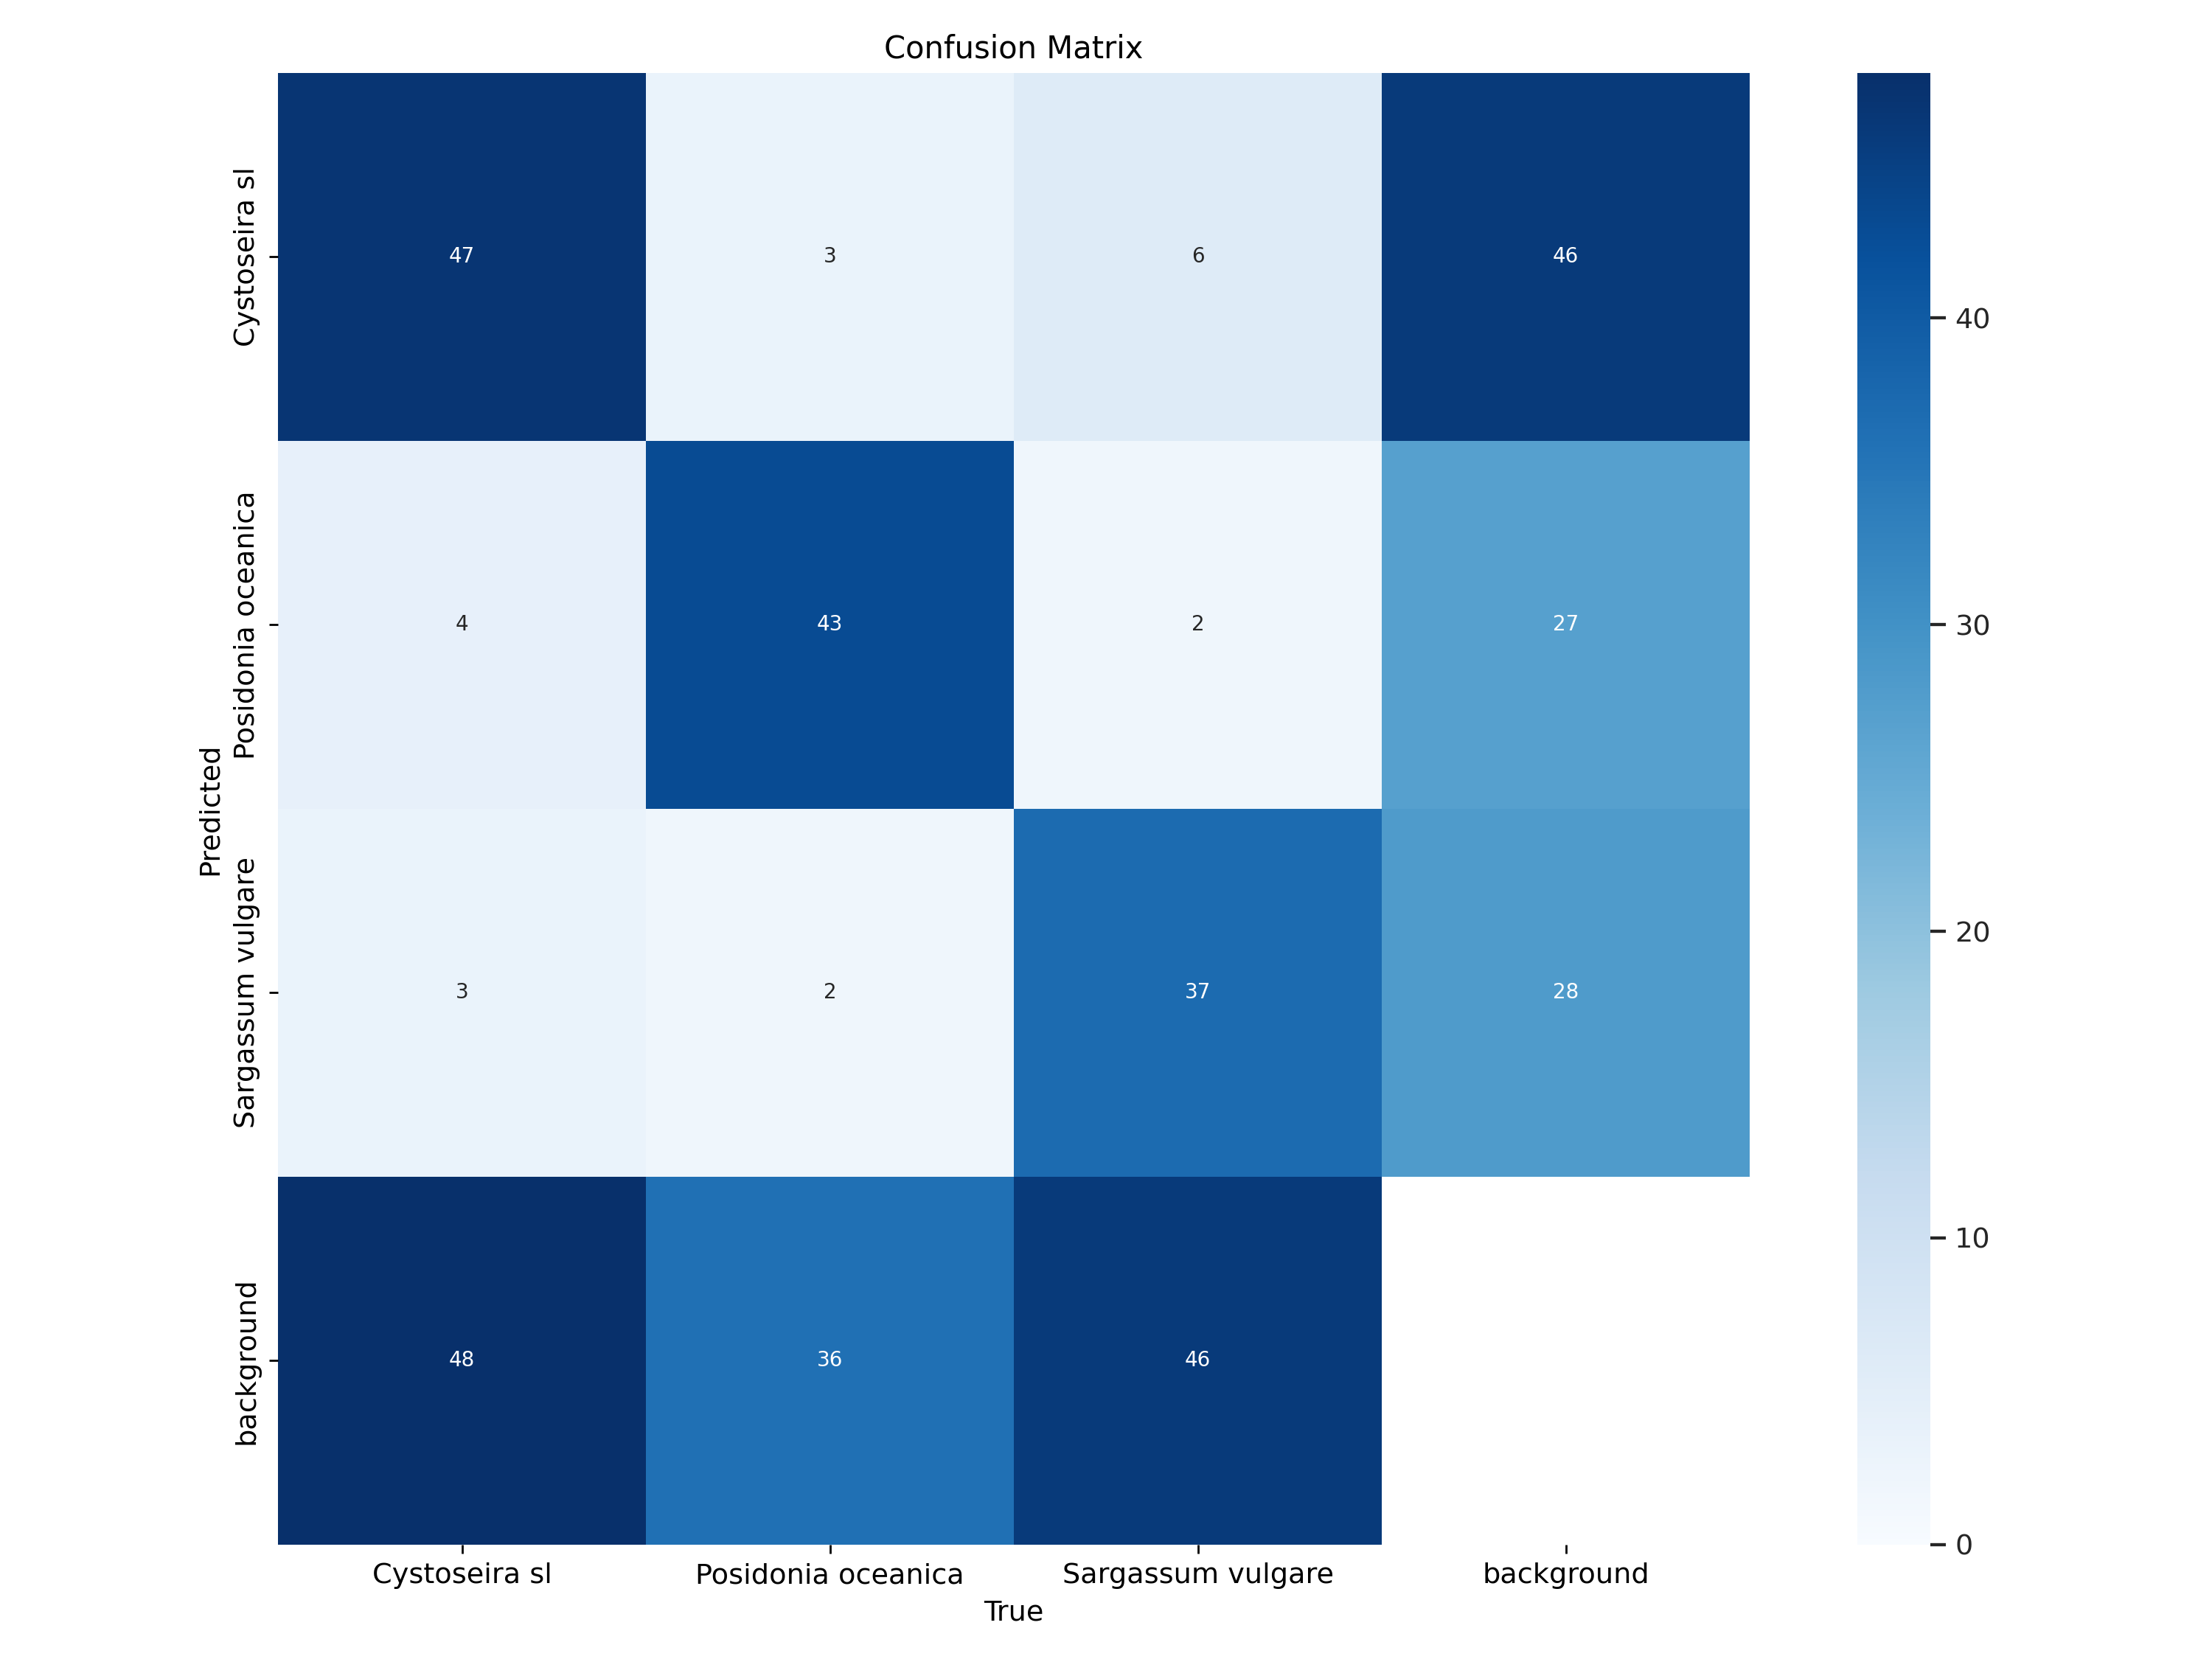

In [31]:
Image(filename="/content/runs/detect/train5/confusion_matrix.png", width=600)

## Evaluate fine-tuned YOLOv12 model

In [32]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train5/

args.yaml					   R_curve.png		val_batch0_labels.jpg
confusion_matrix_normalized.png			   results.csv		val_batch0_pred.jpg
confusion_matrix.png				   results.png		val_batch1_labels.jpg
events.out.tfevents.1743512448.e3b595d566be.168.0  train_batch0.jpg	val_batch1_pred.jpg
F1_curve.png					   train_batch1840.jpg	val_batch2_labels.jpg
labels_correlogram.jpg				   train_batch1841.jpg	val_batch2_pred.jpg
labels.jpg					   train_batch1842.jpg	weights
P_curve.png					   train_batch1.jpg
PR_curve.png					   train_batch2.jpg


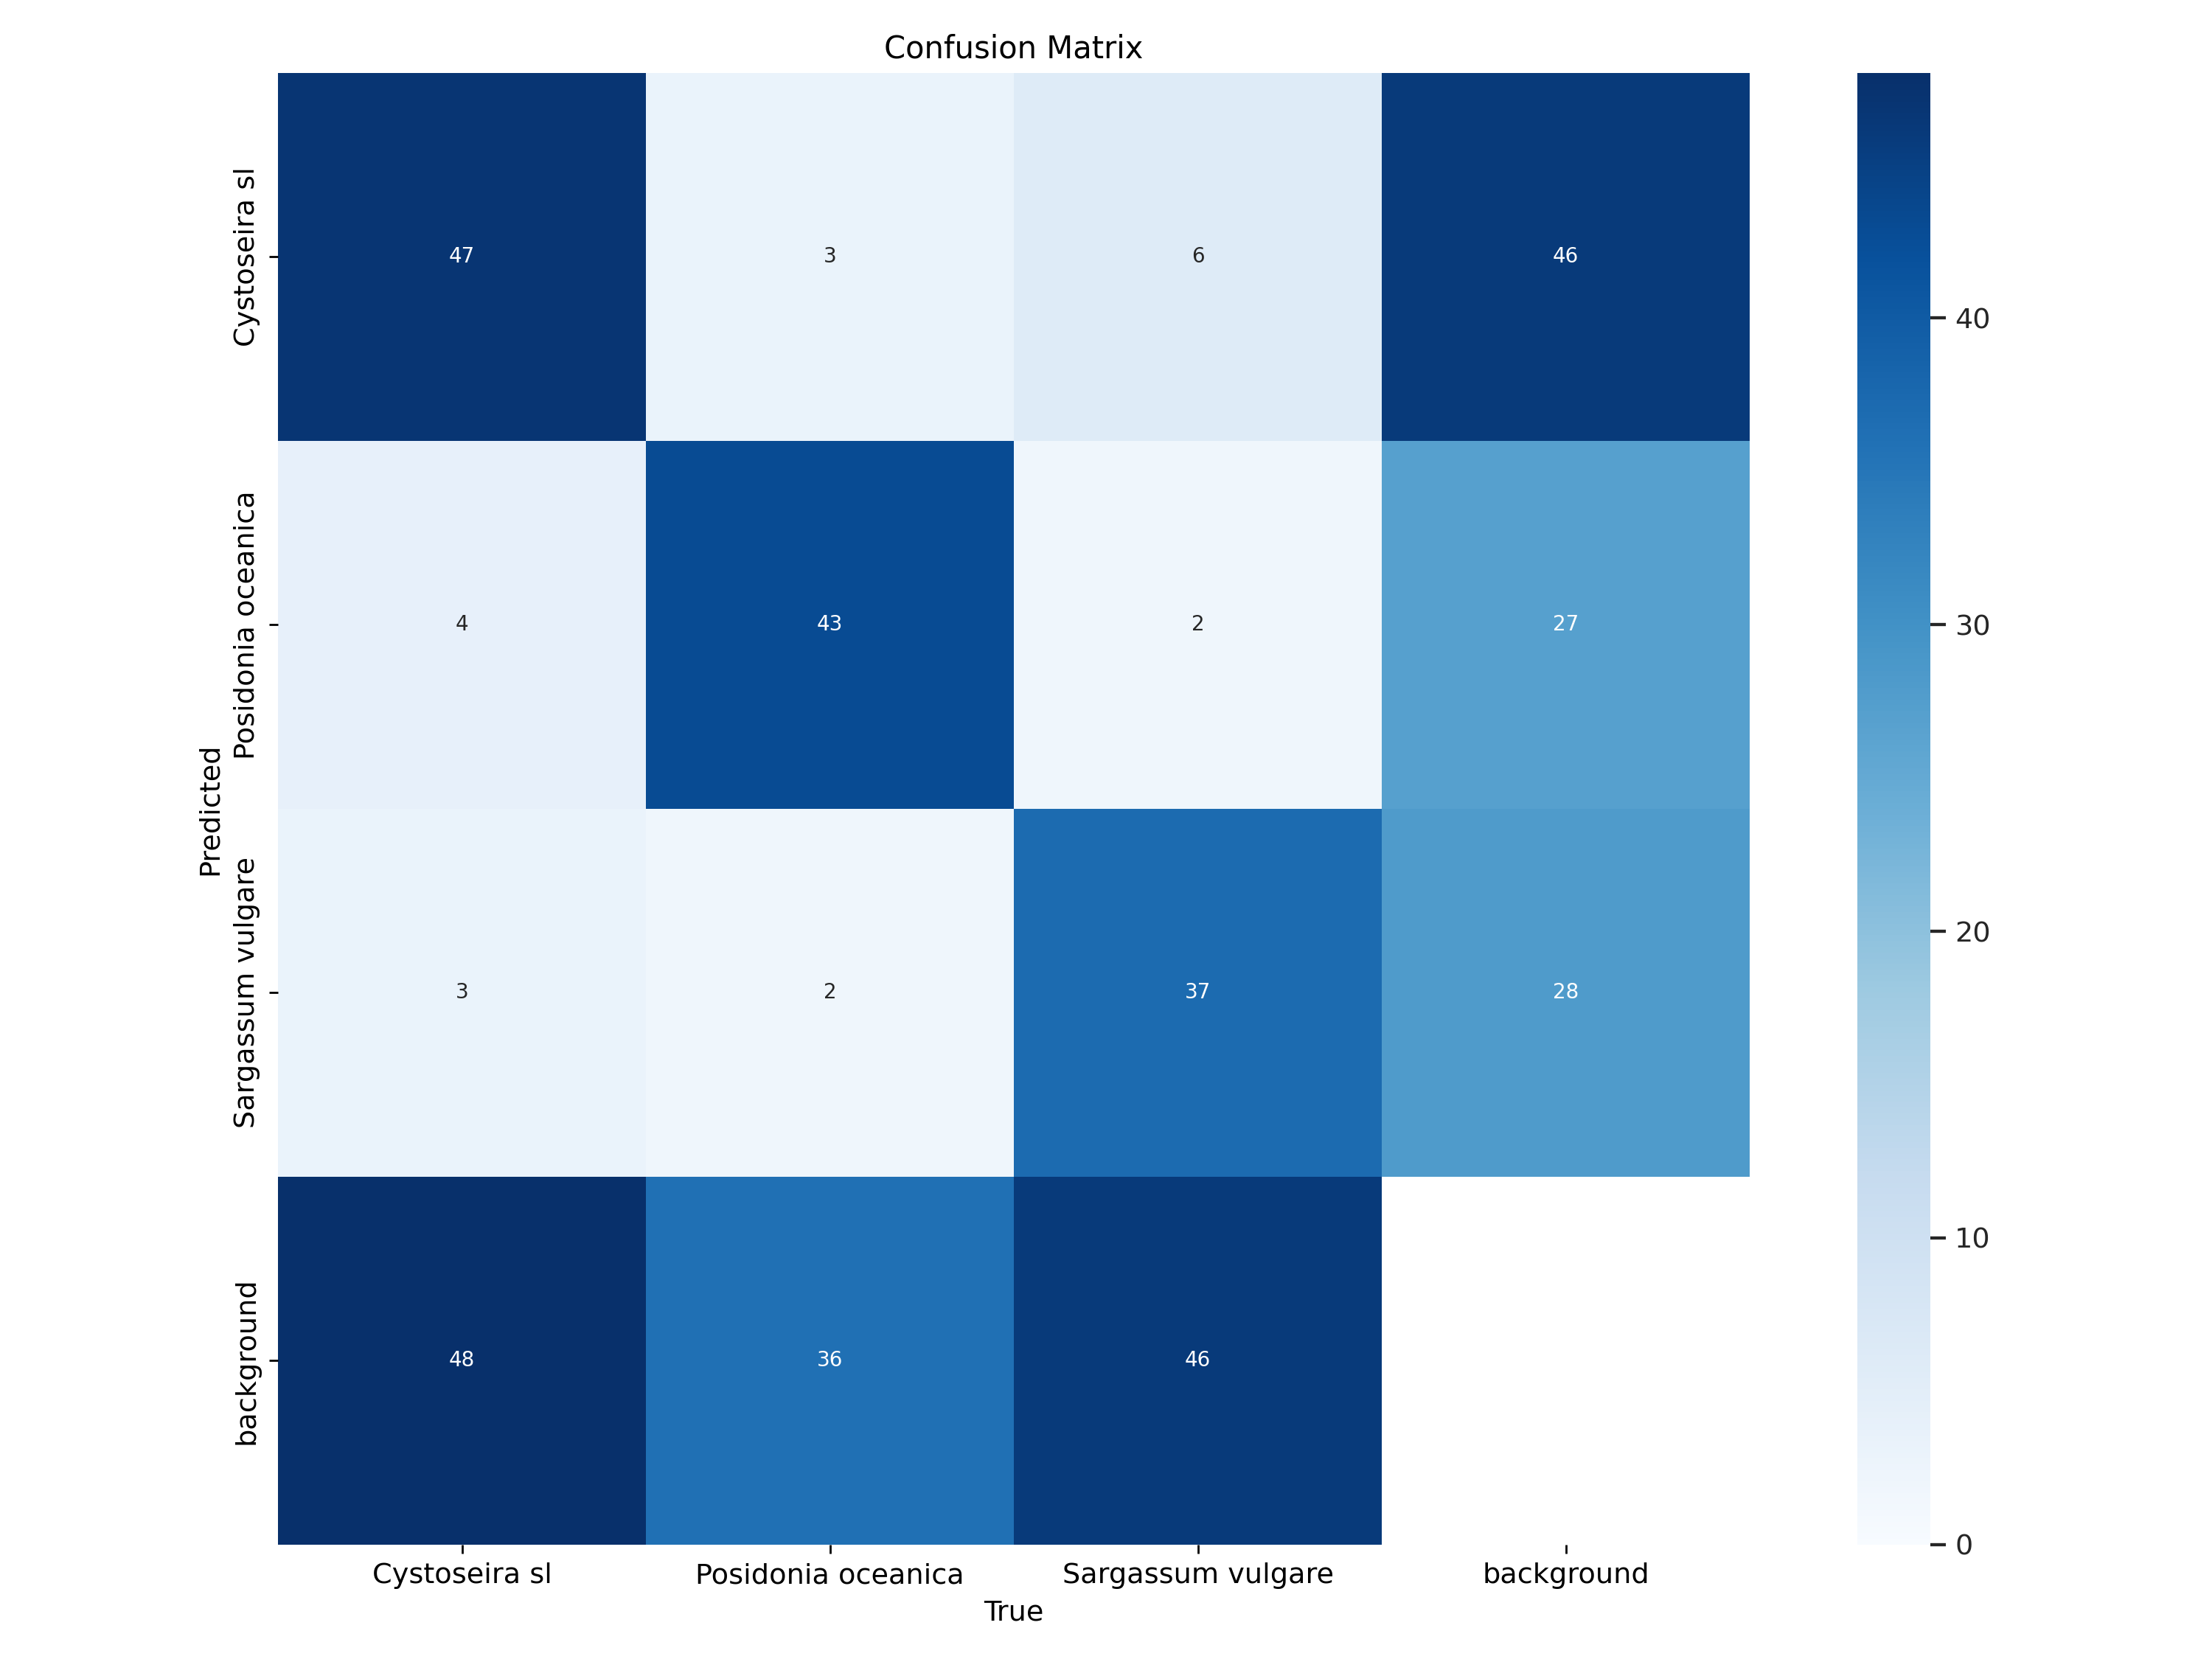

In [33]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train5/confusion_matrix.png', width=1000)

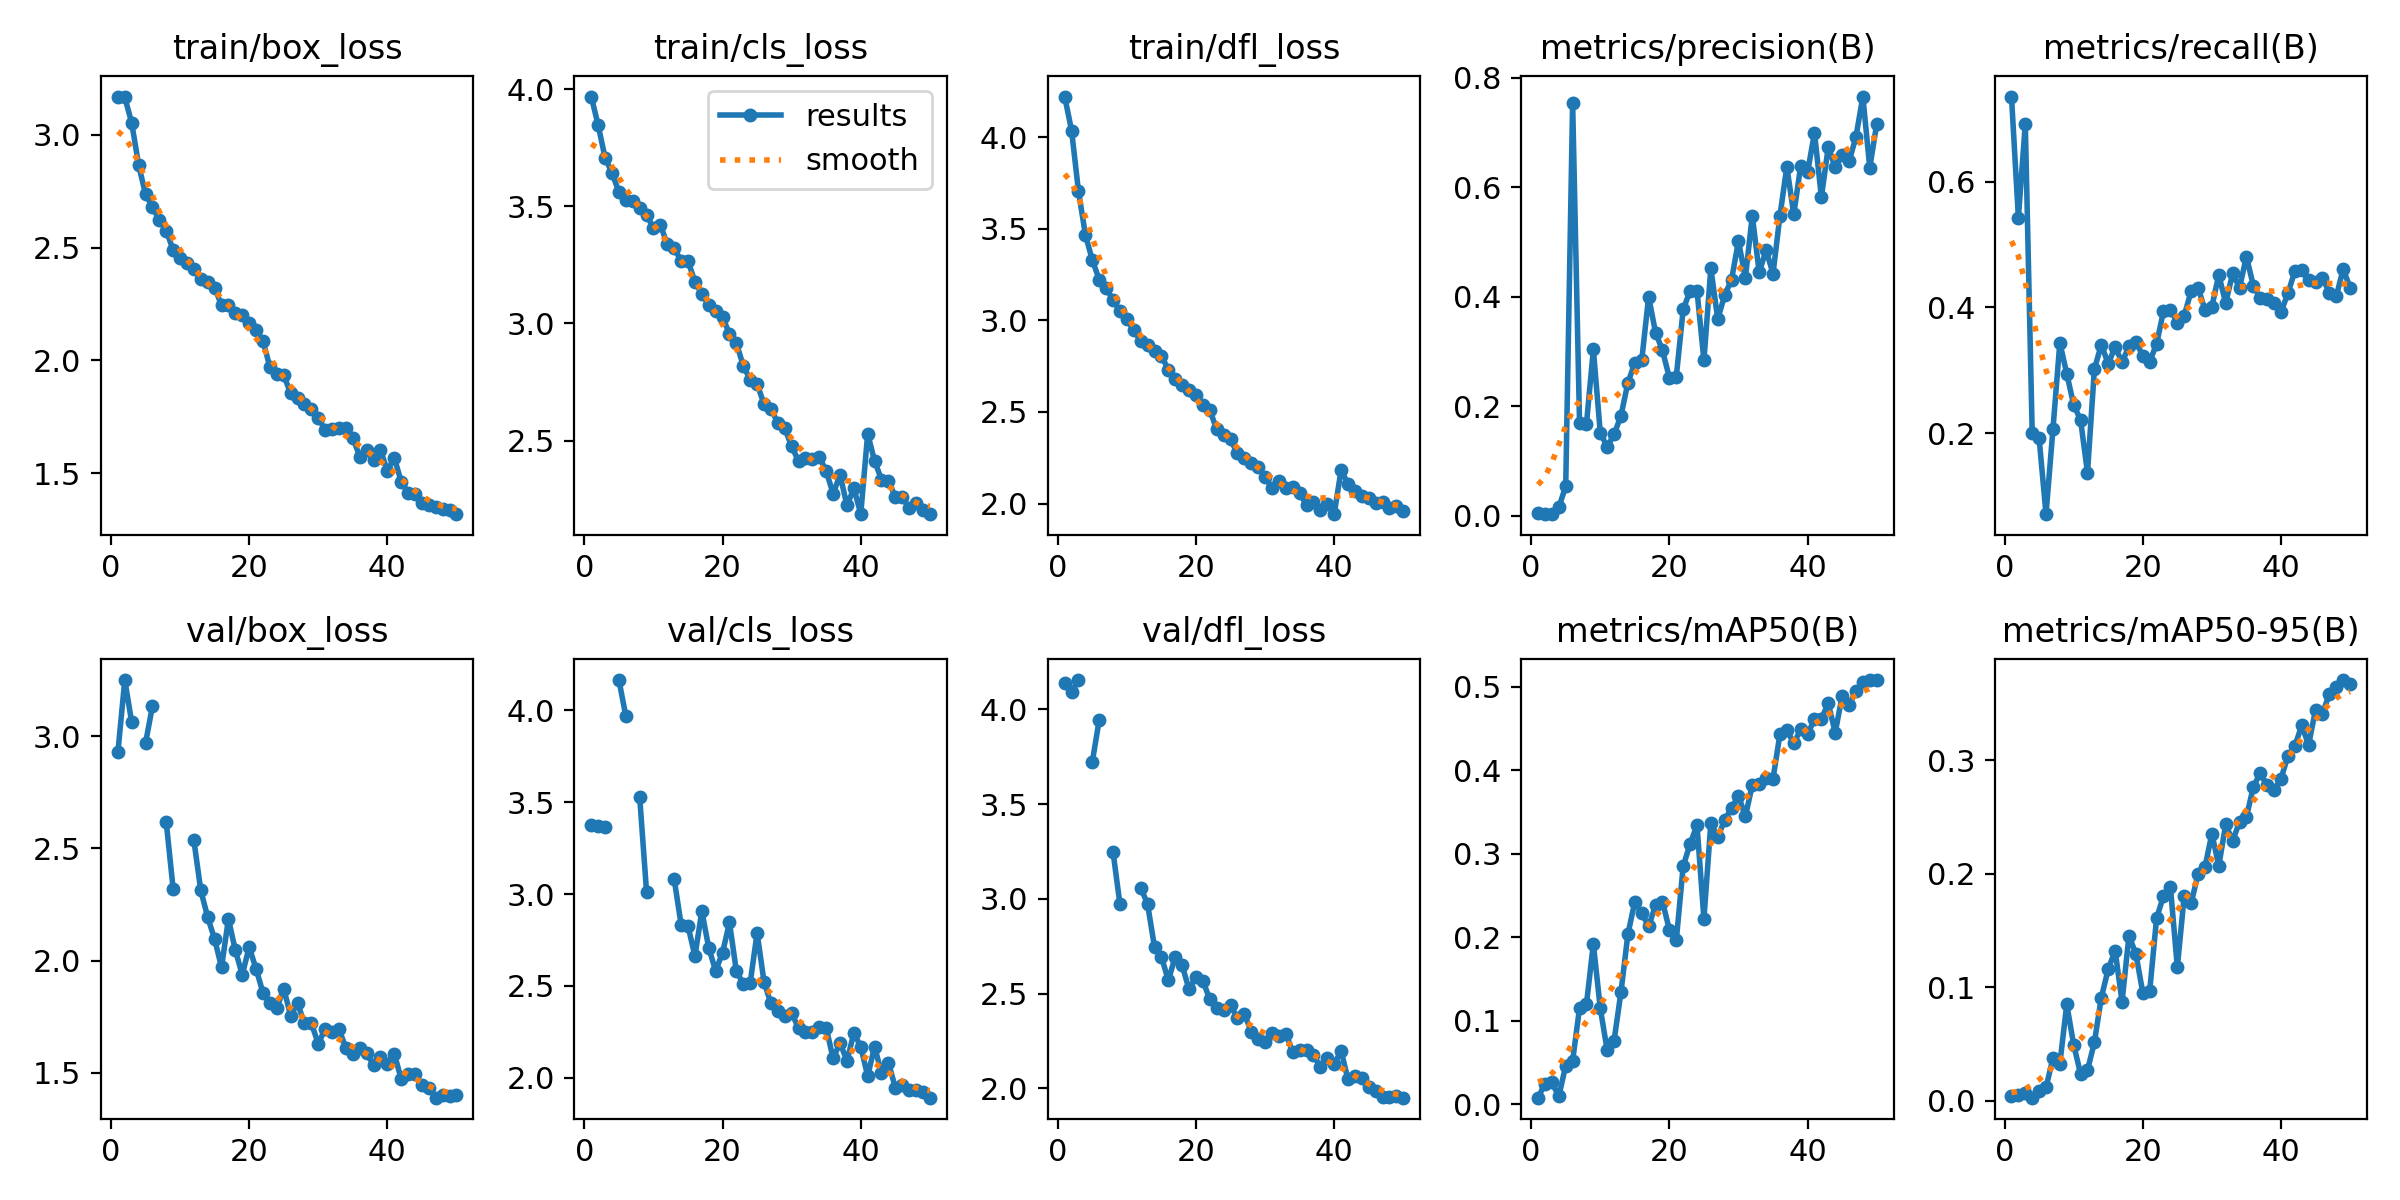

In [34]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train5/results.png', width=1000)

In [39]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"/content/tuscan-macroalgae-recognition-4/test/images",
    annotations_directory_path=f"/content/tuscan-macroalgae-recognition-4/test/labels",
    data_yaml_path=f"/content/tuscan-macroalgae-recognition-4/data.yaml"
)

ds.classes

['Cystoseira sl', 'Posidonia oceanica', 'Sargassum vulgare']

In [40]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/content/runs/detect/train5/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [41]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.3277061084779679
mAP 50 0.44373302180137913
mAP 75 0.35452806746297666


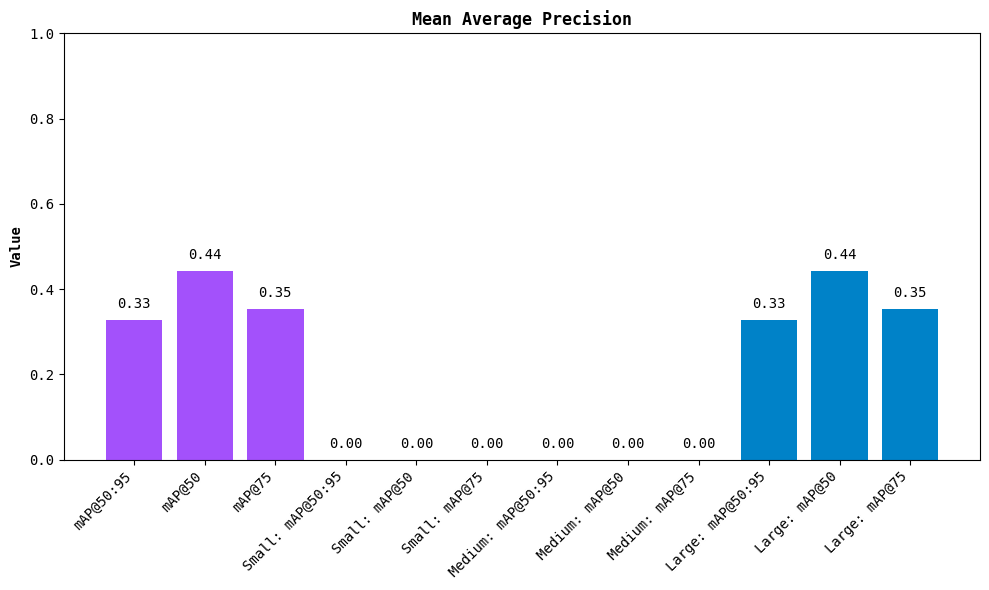

In [42]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [46]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train5/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"/content/tuscan-macroalgae-recognition-4/test/images",
    annotations_directory_path=f"/content/tuscan-macroalgae-recognition-4/test/labels",
    data_yaml_path=f"/content/tuscan-macroalgae-recognition-4/data.yaml"
)

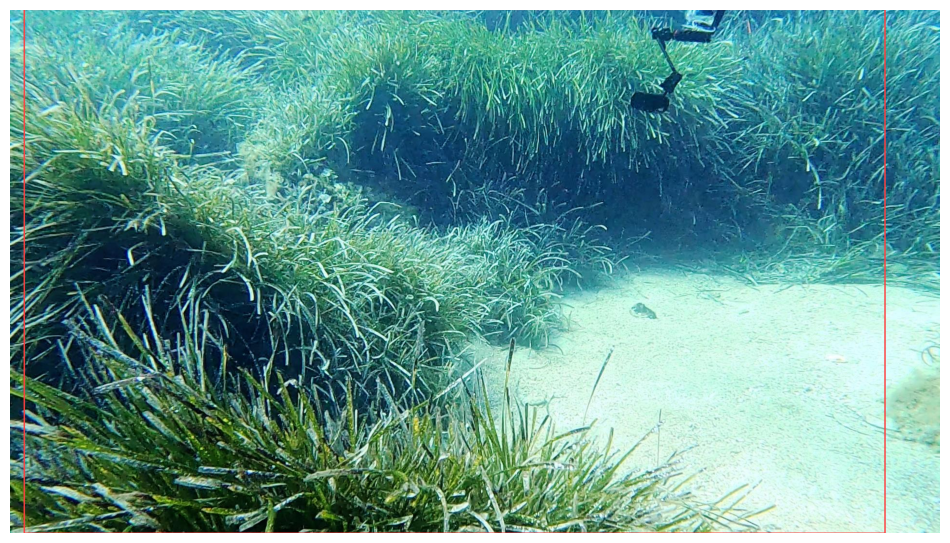

In [47]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)